In [1]:
import gymnasium as gym
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
import ale_py  # Ensure Atari environments work
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import numpy as np
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env
import collections
import random
from gymnasium.wrappers import GrayscaleObservation, ResizeObservation
import re

In [2]:
env = gym.make("ALE/Frogger-v5", render_mode="rgb_array", frameskip=4, repeat_action_probability=0, mode=0)

state, info = env.reset()

A.L.E: Arcade Learning Environment (version 0.10.2+c9d4b19)
[Powered by Stella]


In [3]:
state.shape

(210, 160, 3)

In [4]:
info

{'lives': 4, 'episode_frame_number': 0, 'frame_number': 0}

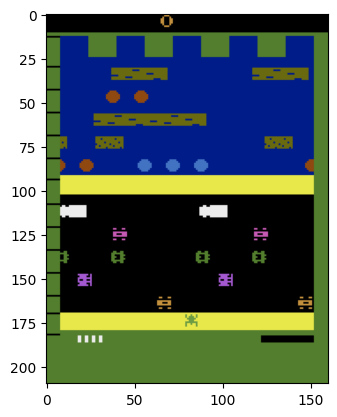

In [5]:
plt.imshow(state)

In [6]:
from dotenv import load_dotenv
import os
load_dotenv()

True

In [7]:
# from google import genai
# client = genai.Client(api_key=os.environ.get("GOOGLE_API_KEY"))

In [8]:
# from anthropic import Anthropic

# client = Anthropic(api_key=os.environ.get("CLAUDE_API_KEY"))

In [10]:
from openai import OpenAI

client = OpenAI(
    api_key=os.getenv("DASHSCOPE_API_KEY"),
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1",
)

In [11]:
from PIL import Image

def save_state(state, step):   
    im = Image.fromarray(state)
    os.makedirs('states', exist_ok=True)
    im.save(f"states/{step}.png")

In [12]:
def call_gemini(prompt, step, actions):
    contents = []
    for s in range(step-2, step+1):
        contents.append(f'Step {s}: action {index_to_action(actions[s][0])} reward {actions[s][1]}')
        contents.append(Image.open(f'states/{s}.png'))
    contents.append(prompt)
    
    print(contents)

    response = client.models.generate_content(
        model="gemini-2.0-flash",
        contents=contents,
        config = {
            'response_mime_type': 'application/json',
            'response_schema': { "type": "OBJECT",
                "properties": {
                    "reasoning": { "type": "STRING", "description": "Step by step reasoning on which action to perform" },
                    "action": { "type": "STRING", "enum": ["NOOP", "UP", "RIGHT", "LEFT", "DOWN"], "description": "Next action to perform" }
                },
                "required": ["reasoning", "action"],
                "propertyOrdering": ["reasoning", "action"]
            }
        }
    )
    response = json.loads(response.text)
    print(response['reasoning'])
    return response['action']

In [13]:
import base64

def image_to_base64(path):
    with open(path, "rb") as image_file:
        binary_data = image_file.read()
        base_64_encoded_data = base64.b64encode(binary_data)
        base64_string = base_64_encoded_data.decode('utf-8')
        return base64_string

In [14]:
def call_claude(prompt, step, actions):
    MODEL_NAME = "claude-3-7-sonnet-20250219"
    content = []
    for s in range(step-2, step+1):
        content.append({"type": "text", "text": f'Step {s}: <action>{index_to_action(actions[s][0])}</action> reward {actions[s][1]}'})
        content.append({"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": image_to_base64(f'states/{s}.png')}})
    content.append({"type": "text", "text": prompt})

    message_list = [
        {
            "role": 'user',
            "content": content
        }
    ]
    print(message_list)

    response = client.messages.create(
        model=MODEL_NAME,
        max_tokens=500,
        messages=message_list
    )

    res = response.content[0].text
    print(res)
    match = re.search("<action>(.+)</action>", res)
    if match:
        return match[1]
    else:
        return "NOOP"

In [23]:
def call_openai(prompt, step, actions):
    content = []
    for s in range(step-2, step+1):
        content.append({"type": "text", "text": f'Step {s}: <action>{index_to_action(actions[s][0])}</action> reward {actions[s][1]}'})
        content.append({"type": "image_url", "image_url": {"url": f'data:image/png;base64,{image_to_base64(f"states/{s}.png")}'}})
    content.append({"type": "text", "text": prompt})

    message_list = [
        {
            "role": 'user',
            "content": content
        }
    ]
    completion = client.chat.completions.create(
        model="qwen2.5-vl-72b-instruct",
        messages=message_list
    )

    res = completion.choices[0].message.content
    print(res)
    match = re.search("<action>(.+)</action>", res)
    if match:
        return match[1]
    else:
        return "NOOP"


In [24]:
import json

max_steps = 1000

import enum

actions_dict = { "NOOP": 0, "UP": 1, "RIGHT": 2, "LEFT": 3, "DOWN": 4 }

def action_to_index(action: str) -> int:
    return actions_dict[action]

def index_to_action(index: int) -> str:
    return list(actions_dict.keys())[index]

state, info = env.reset()
actions = []

# skip over initial 109 frames (with default frameskip=4) where control is not enabled
for step in range(109):
    state, reward, terminated, truncated, _ = env.step(0)
    save_state(state, step)
    actions.append((0, 0))

total_reward = 0
while step < max_steps:
    # with open('frogger_manual.txt', 'r') as f:
    #     prompt = f.read()
    prompt = "\n\nGiven past frames, reason step by step to choose one of the five actions: NOOP, UP, RIGHT, LEFT, DOWN."
    prompt += "Enclose the action you pick in <action></action>"

    action = call_openai(prompt, step, actions)
    action = action_to_index(action)

    with open('actions.json', 'w+') as f:
        f.write(json.dumps(actions))
    print(f'Step {step} action: {action} total reward: {total_reward}')

    state, reward, terminated, truncated, _ = env.step(action)
    actions.append((action, reward))
    total_reward += reward
    step += 1

    save_state(state, step)

    if terminated or truncated:
        print('GAME ENDED')
        break

    state, reward, terminated, truncated, _ = env.step(0)
    total_reward += reward
    if terminated or truncated:
        print('GAME ENDED')
        break

print(f'Total reward: {total_reward}')

To determine the appropriate action, let's analyze the current state of the game and the potential outcomes of each action:

1. **Current State Analysis**:
   - The player is at the bottom of the screen.
   - There are obstacles (green blocks) above the player.
   - There are enemies (pink creatures) moving around.
   - The player needs to navigate through the obstacles and avoid the enemies.

2. **Action Evaluation**:
   - **NOOP**: Doing nothing will not change the player's position. This might be useful if the player is in a safe spot and waiting for an opportunity to move.
   - **UP**: Moving up will bring the player closer to the obstacles. This could be risky if the player is not aligned with a gap in the obstacles.
   - **RIGHT**: Moving right will bring the player closer to the right side of the screen. This could be useful if there is a path on the right side.
   - **LEFT**: Moving left will bring the player closer to the left side of the screen. This could be useful if there 

In [27]:
os.system("ffmpeg -i states/%01d.png -vcodec mpeg4 -y movie.mp4")

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

0